In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
import yfinance as yahooFinance
import pandas_datareader as web

import warnings
warnings.filterwarnings("ignore")

In [21]:
df = web.DataReader('JPY=X', data_source='yahoo',start='2018-01-01',end='2022-11-06')

In [23]:
data

,Close
Date,
2018-01-01,112.666000
2018-01-02,112.769997
2018-01-03,112.244003
2018-01-04,112.607002
2018-01-05,112.782997
...,...
2022-10-31,147.811996
2022-11-01,148.737000
2022-11-02,147.914993


Text(0, 0.5, 'Prices ($)')

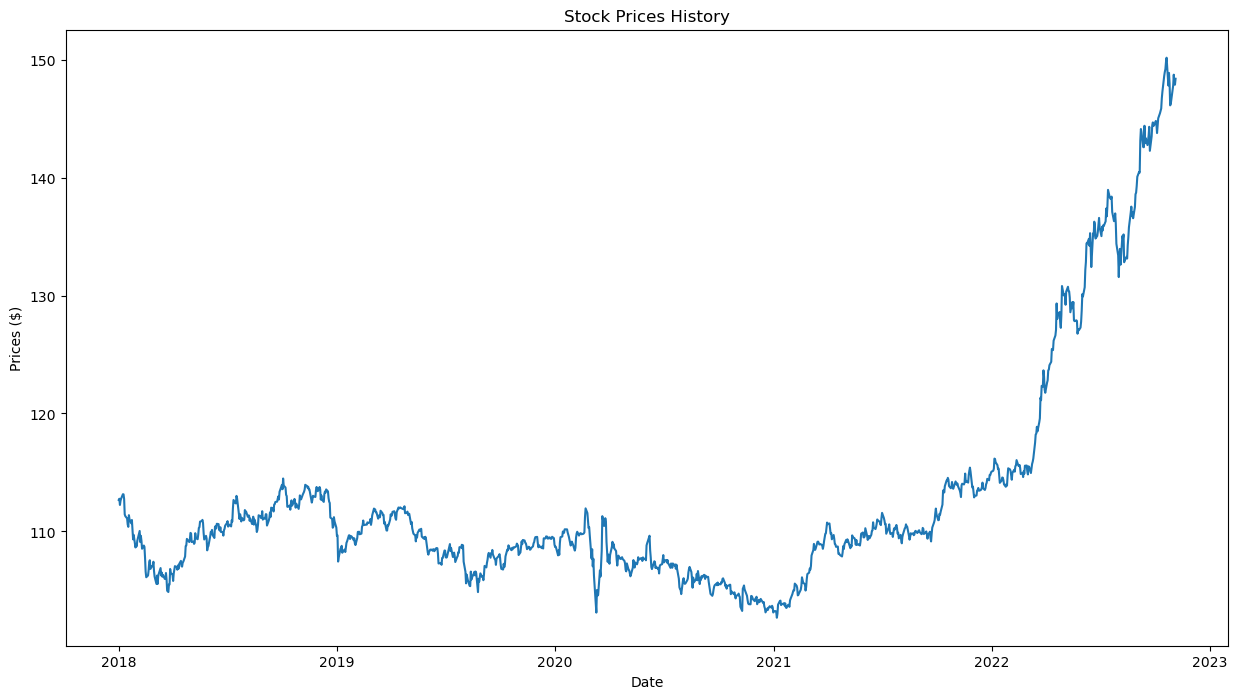

In [24]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [25]:
temp = data[["Close"]]
prediction_days=90
temp['Prediction'] = temp[['Close']].shift(-prediction_days)
X = np.array(temp.drop(['Prediction'],1))
X = X[:len(temp)-prediction_days]
y = np.array(temp['Prediction'])
y = y[:-prediction_days]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
prediction_days_array = np.array(temp.drop(['Prediction'],1))[-prediction_days:]

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr = SVR()
param_grid_svr = [
    {
    'kernel':['linear','rbf', 'sigmoid'],
    'gamma':['scale', 'auto'],
    'shrinking':[True , False],
    'verbose':[True, False]
    }
]
param_svr = GridSearchCV(svr, param_grid = param_grid_svr, cv = 5, verbose=True,scoring="r2")

best_param_svr = param_svr.fit(x_train,y_train)
best_param_svr.best_params_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [26]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='linear',shrinking=True,verbose=True, C=1e3, gamma='scale')
svr_rbf.fit(x_train,y_train)
svr_rbf_confidence = svr_rbf.score(x_test, y_test)
print("svr_rbf_confidence :", svr_rbf_confidence)

[LibSVM]svr_rbf_confidence : 0.8120945969997418


In [27]:
svm_prediction = svr_rbf.predict(x_test)
svm_prediction = svr_rbf.predict(prediction_days_array)

In [28]:
Close = temp[['Close']]
Prediction = temp[['Prediction']]
Prediction.dropna(inplace=True)
Close.reset_index(inplace=True)
Close = Close.loc[:,['Date','Close']]
Prediction.reset_index(inplace=True)
Prediction.drop(columns=['Date'])
Prediction = Prediction[['Prediction']]
svm_prediction =pd.DataFrame(svm_prediction)
Prediction = pd.concat([Prediction,svm_prediction],axis=0)

In [31]:
from math import nan
from datetime import timedelta
Lastday = Close['Date'].iloc[-1]
empty = []
for day in range(1,91):
    empty.append(Lastday + timedelta(days=day))
empty=pd.DataFrame(empty)
TempDate = pd.concat([Close['Date'],empty],axis=0)
dummy = []
for no in range(1,91):
    dummy.append(nan)
dummy = pd.DataFrame(dummy)
TempClose = pd.concat([Close['Close'],dummy],axis=0)
Closing = pd.concat([TempDate,TempClose],axis=1)
Closing.set_axis(['Date', 'Close'], axis='columns', inplace=True)
Host = pd.DataFrame(Prediction[0][-90:])
dummy=[]
for no in range(0,len(data)):
    dummy.append(nan)
dummy = pd.DataFrame(dummy)
TempPred = pd.concat([dummy,Host],axis=0)
TempPred.rename(columns = {0:'Prediction'}, inplace = True)
Closing = pd.concat([Closing,TempPred],axis=1)
Closing = Closing.set_index('Date')


<AxesSubplot:title={'center':'JPY=X'}, xlabel='Date'>

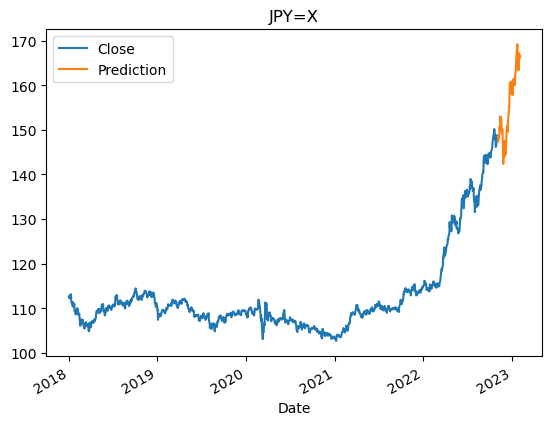

In [32]:
Closing.plot(title='JPY=X')